In [1]:
# Ref: https://bobrupakroy.medium.com/lstms-for-regression-cc9b6677697f

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
# fix the random seed
np.random.seed(7)

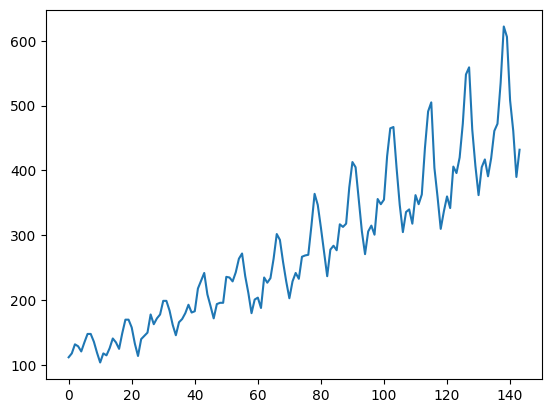

In [4]:
# load the dataset)
dataframe = read_csv('/content/drive/MyDrive/Learn/Mahara-tech/AirPassengers.csv', usecols=[1])
plt.plot(dataframe)

In [5]:
dataframe.head()

,#Passengers
0,112
1,118
2,132
3,129
4,121


In [6]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #COnvert values to float

In [7]:
# LSTM is sensetive to the scale of input data, so it is a good practice to re-scale the data to the range of 0-1,
# also called normalizing
# Normalization is optional but recommended for neural network as certain
# activation functions are sensitive to magnitude of numbers.
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)


In [8]:
# Cannot use random way of splitting dataset into train and test as the sequence of events is important for time series.
# Take first 67% values for train and the remaining 33% for testing
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

96 48


## Different types of Long Short-Term Memory Network

1. LSTM for Regression
2. LSTM using Window Method
3. LSTM time Step Framing
4. LSTM Memory Between Batches
5. Stacked LSTM with Memory Between Batches

**1- LSTM for Regression**

• It requires X & Y independent and dependent variables for the algorithm to train, so we will first convert our data into such format.

• What we will do will first take the passenger_numbers data(t) in our first column then the second column will have the data(t+1) passenger_numbers data that we will use to predict.

• The dataset format will be X and Y, where X is the passenger_numbers at a given time(t) and Y is the passenger_numbers at the next time (t+1) and look_back is the number of previous time steps to be as input(X) variable to predict the next time step(y)

**2- LSTM using Window Method**

• Increasing the multiple time steps to make the prediction for the next time step

• For example Y will be our current timestamp (t) and we need to predict the next timestamp (t+1). What we will do is we will use the current time step (t) as well as two prior time steps ( t-1, t-2) as input variables(X)

• So we only need to change the loop_back value = 3 that will take t-1,t-2,t.


• The intuition behind this is the more data we have to train our model the more accuracy we get and also that doesn’t mean you will put loop_back value = 100-time steps, it’s like repeating the similar pattern of time steps 100times will give you less accuracy, we need to find a balance.

**3. LSTM time Step Framing**

- Instead of phrasing the past observations as separate input features, we can use them as time steps of the one input feature, which is indeed a more accurate framing of the problem

- Reshape input to be [samples, time steps, features] and put back the feature dimension = 1

code:

trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

**4. LSTM with Memory Between Batches** ~ Stateful LSTM

- The LSTM network has a memory that is capable of remembering across long sequences.

- The state within the network is reset after each training batch when fitting the model as well as each call to model.predict() or model.evaluate()

- We can have more control over the internal state of the LSTM network is cleared in Keras by making the LSTM layer “stateful”.

- This means that it can build state over the entire training sequence and even maintain that state if needed to make predictions and also it requires the training data is not to be shuffled when fitting the network.

- It also requires explicit resetting of the network state after each exposure to the training data(epoch) by calls to model.reset_staes().

- Thus we have must create our own outer loop of epochs and within each epoch call model.fit() and model.reset_states()

code:

for i in range(100):

model.fit(trainX, trainY, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)

model.reset_states()

- We have to hard code the samples, time steps, and the number of features in a time step by setting the batch_input_shape parameter.

code:

batch_size = 1

model = Sequential()

model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
T
- The same batch size value needs to be used during prediction or any evaluation.

**5. Stacked LSTMs with Memory between Batches**

- The LSTM layer prior to each subsequent LSTM layer must return the sequence by settings the return_sequences parameter on the layer to ‘True”.

code:

model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))

model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))

In [9]:
# This function takes 2 inputs: the dataset and the lookback, to convert an array of values to a dataset matrix
# lookback is the previous timesteps to use as an input to predict the next time period

def create_dataset(dataset, lookback=1):
  dataX, dataY = [], []
  # loopback-1 : to see previous input
  for i in range(len(dataset)-lookback-1):
    # to access the 2d numpy array and get the element at zero index, eg: #m = np.array([[1,2,3],[4,5,6]]) #print(m) #m[0:2, 0]
    a = dataset[i:(i+lookback), 0]
    # print(dataset[i:(i+lookback), 0], "\n", dataset[i:(i+lookback)]) # break
    dataX.append(a)
    dataY.append(dataset[i+lookback, 0])
  return np.array(dataX), np.array(dataY)

In [10]:
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(testX, "\n")
print(testY, "\n")
# the shape is (num_samples, num_features)
print(testX.shape)

[[0.4073359  0.3803089  0.48648646 0.47104248 0.484556  ]
 [0.3803089  0.48648646 0.47104248 0.484556   0.6138996 ]
 [0.48648646 0.47104248 0.484556   0.6138996  0.6969112 ]
 [0.47104248 0.484556   0.6138996  0.6969112  0.70077217]
 [0.484556   0.6138996  0.6969112  0.70077217 0.57915056]
 [0.6138996  0.6969112  0.70077217 0.57915056 0.46911195]
 [0.6969112  0.70077217 0.57915056 0.46911195 0.38803086]
 [0.70077217 0.57915056 0.46911195 0.38803086 0.44787642]
 [0.57915056 0.46911195 0.38803086 0.44787642 0.45559844]
 [0.46911195 0.38803086 0.44787642 0.45559844 0.4131274 ]
 [0.38803086 0.44787642 0.45559844 0.4131274  0.4980695 ]
 [0.44787642 0.45559844 0.4131274  0.4980695  0.47104248]
 [0.45559844 0.4131274  0.4980695  0.47104248 0.49999997]
 [0.4131274  0.4980695  0.47104248 0.49999997 0.6389961 ]
 [0.4980695  0.47104248 0.49999997 0.6389961  0.7471043 ]
 [0.47104248 0.49999997 0.6389961  0.7471043  0.7741313 ]
 [0.49999997 0.6389961  0.7471043  0.7741313  0.57915056]
 [0.6389961  0

In [11]:
# the lstm expects the input to be provided with specific array in the form of: [samples, timesteps, features]
# so we have to add a time step by reshaping
trainX = np.reshape(trainX, (trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1]))
print(trainX.shape, " ",testX.shape )

(90, 1, 5)   (42, 1, 5)


In [12]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 160       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 165 (660.00 Byte)
Trainable params: 165 (660.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1, validation_data=(testX, testY))

Epoch 1/100
90/90 [==============================] - 6s 20ms/step - loss: 0.0146 - val_loss: 0.0683
Epoch 2/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0438
Epoch 3/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0375
Epoch 4/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0335
Epoch 5/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0287
Epoch 6/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0236
Epoch 7/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0211
Epoch 8/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0209
Epoch 9/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0194
Epoch 10/100
90/90 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0187
Epoch 11

In [14]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# inverse transformation is do undo the scale effect, so that your predictions are in the same scale
# as prior MinMaxScaler (thousands of passenger per month)
trainPredict_inverse = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict_inverse = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

2/2 [==============================] - 0s 4ms/step


In [16]:
# calculate root mean squared error
#print(trainY_inverse, "\n \n ", trainPredict)
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict_inverse[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict_inverse[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.28 RMSE
Test Score: 62.46 RMSE


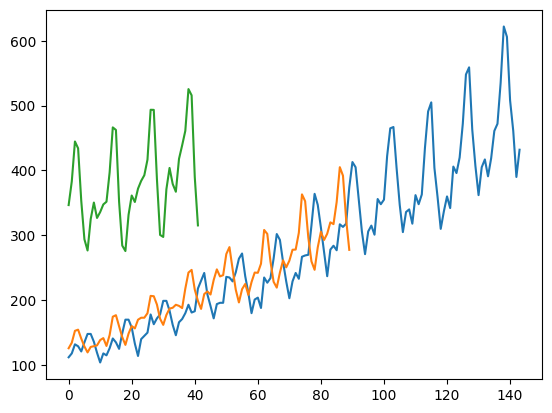

In [17]:
# The data is shifted
plt.plot(scaler.inverse_transform(dataset)) # Blue
plt.plot(trainPredict_inverse) # orange
plt.plot(testPredict_inverse) # green
plt.show()

In [18]:
# we must shift the predictions so that they align on the x-axis with the original dataset.

# shift train predictions for plotting
# np.empty_like(): Return a new array with the same shape and type as a given array.
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
# starting from index 5 (the 6th element) till the len(trainPredict_inverse) + 5
trainPredictPlot[look_back:len(trainPredict_inverse)+look_back, :] = trainPredict_inverse

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
# start from len(trainPredict_inverse) + 5, then skip the look_back same as trainPredictPlot
testPredictPlot[len(trainPredict_inverse)+(look_back*2)+1:len(dataset)-1, :] = testPredict_inverse

#print(len(trainPredict_inverse)+(look_back*2)+1) # 101 == len(train) + look_back = 96 + 5
#print(len(testPredict_inverse))
#print(len(testPredictPlot[len(trainPredict_inverse)+(look_back):len(dataset)-1, :]))
#print(len(testPredictPlot[len(trainPredict_inverse)+(look_back*2)+1:len(dataset)-1, :]))

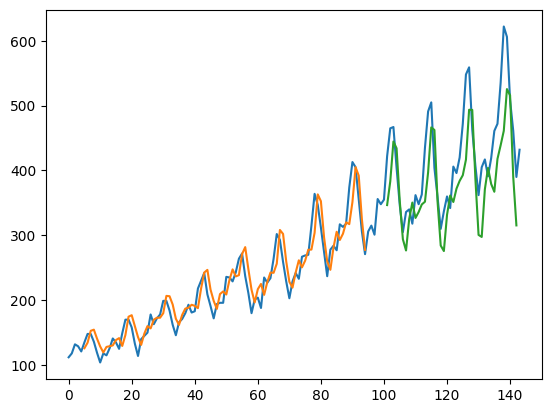

In [20]:
# The data is shifted
plt.plot(scaler.inverse_transform(dataset)) # Blue
plt.plot(trainPredictPlot) # orange
plt.plot(testPredictPlot) # green
plt.show()

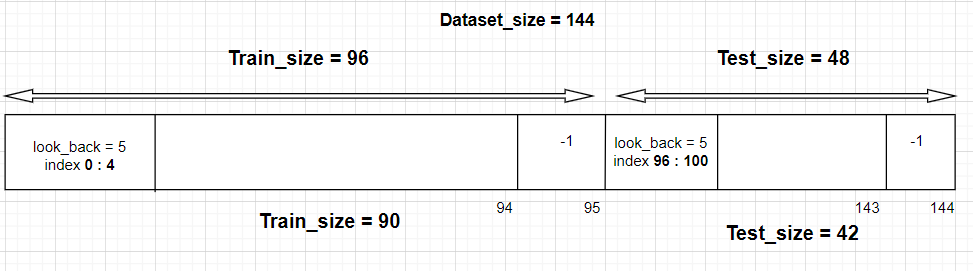